In [7]:
import random as rand
import json
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from datetime import datetime

from matplotlib import pyplot as plt
from utils.drawdown import Drawdown_plot
from Port.SharpRU import SharpPortfolio
from Port.Markowitz_scipy import MarkowitzPortfolio
from Port.Tobin_scipy import TobinPortfolio

# Загрузка данных для работы

In [8]:
with open('utils/config.json', 'r') as file:
    config = json.load(file)
    
start = config['start_date']
end = config['end_date']
riskfree = 0.077
riskfree_day = ((1+riskfree)**(1/252))-1

In [9]:
moex = pd.read_excel('Data/RU/moex.xlsx', index_col=0)
market = moex.pct_change().iloc[1: ]

pct = pd.read_excel('Data/RU/returns_RU.xlsx', index_col = 0)
pct = pct.pct_change().iloc[1:,:]

In [10]:
pct = pct.dropna(axis=1)

In [11]:
cc = set(pct.index)-set(moex.index)
pct = pct.drop(cc, axis=0)

# Метрики

In [12]:
def get_metrics(df_data):  
    metr = pd.DataFrame()
    
    #Average daily returns
    mean = df_data.mean()
    metr['AVG_returns'] = mean
    
    #Total Return
    
    tot_ret = (df_data+1).cumprod()
    metr['Total Return']=tot_ret.iloc[len(tot_ret)-1,:]

    #Risk
    risk = df_data.std()
    metr['Risk'] = risk

    #Beta

    var_metr = df_data.var()
    cov_metr = df_data.cov()
    beta = cov_metr['market']/var_metr['market']

    metr['Beta'] = beta

    #Alpha

    riskf_daily = ((1+riskfree)**(1/252))-1
    alpha = metr['AVG_returns'] - (riskf_daily + metr['Beta']*(mean['market'] - riskf_daily))
    metr['Alpha'] = alpha
    
    #Sharpe
    
    sharpe = (mean - riskfree_day)/risk
    metr['Sharpe'] = sharpe

    #VaR(95%)

    VaR = - risk*1.65
    metr['VaR(95%)'] = VaR
    
    #Drawdown and Recovery
    portfolio_value = (df_data+1).cumprod() #датафрейм со "стоимостью" портфеля

    recovery = []
    drawdown = []
    for i in range(len(df_data.columns)):
        recovery.append(Drawdown_plot('zelyoniy','sobaka').find_max_recovery(portfolio_value.iloc[:,i])[0])
        drawdown.append(Drawdown_plot(1,1).find_max_drawdown(portfolio_value.iloc[:,i])[0])
    
    metr['Drawdown(%)'] = drawdown
    metr['Recovery(days)'] = recovery

    return metr

# Бэктест 

In [13]:
def backtesting_universal(data, # df with pct_changes
                          port_model = MarkowitzPortfolio,
                          window_train = 24, 
                          window_test = 1,
                          train_start_year = 2018, 
                          train_start_month = 1,
                          test_finish_year = 2022,
                          test_finish_month = 11,
                          **args):
    
    # print(args)
    weights_year = []
    return_portfolio = pd.DataFrame([])
    
    train_start_month = train_start_year * 12 + train_start_month - 1
    test_finish_month = test_finish_year * 12 + test_finish_month - 1
    train_finish_month = test_finish_month - window_train - window_test + 1
    
    for train_start_per in range(train_start_month, train_finish_month, window_test):
        
        train_finish_per = train_start_per + window_train
        
        train_year_start_per = train_start_per // 12
        train_month_start_per = train_start_per % 12 + 1
        
        train_year_finish_per = train_finish_per // 12
        train_month_finish_per = train_finish_per % 12 + 1
        
                
        mask_train = (data.index > datetime(train_year_start_per, train_month_start_per, 1)) & (data.index < datetime(train_year_finish_per, train_month_finish_per, 1))
        data_train_per = data[mask_train]
        
        
        mu = (((data_train_per + 1).prod()) ** (1 / len(data_train_per)) - 1).values * 252  # средняя доходность за год (252 раб дня)
        Sigma = data_train_per.cov().values * 252  # ковариационная матрица за год (252 раб дня)

        port_ = port_model(mu, Sigma, args=args)
        weights, _ = port_.fit()
        weights_year.append(weights)
        
        
        test_year_start_per = train_year_finish_per
        test_month_start_per = train_month_finish_per
        
        test_finish_per = train_finish_per + window_test
        
        test_year_finish_per = test_finish_per // 12
        test_month_finish_per = test_finish_per % 12 + 1
        
        # print(train_year_start_per, train_month_start_per,  train_year_finish_per, train_month_finish_per, test_year_finish_per, test_month_finish_per)
        
                
        mask_test = (data.index > datetime(test_year_start_per, test_month_start_per, 1)) & (data.index < datetime(test_year_finish_per, test_month_finish_per, 1))
        data_test_per = data[mask_test]
        
        #print(data_test_per, weights)
        #print(data_test_per.shape, weights.shape)
        return_portfolio_loc = pd.DataFrame(data_test_per.values @ weights, index=data_test_per.index,
                                            columns=[f'{port_model.__name__}'])
        

        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
    
    # return_portfolio['market'] = market.loc[return_portfolio.index]

    return return_portfolio

# Создание портфеля

#### Один портфель

In [14]:
def get_port(asset_list, portfolio_type = MarkowitzPortfolio, max_risk=1, min_ret=((1+riskfree)**(1/252))-1):
    
    asset_pct = pct[asset_list]
    
    asset_rets = backtesting_universal(asset_pct, port_model = portfolio_type, ret_det=(1+riskfree)**(1/252)-1, risk_det=1)
    
    asset_price = (asset_rets+1).cumprod()
    plt.plot(asset_price)
    plt.show()
    
    return asset_rets, asset_price

### Шарп

In [15]:
def get_sharpe(df_pct,n):
    sharpe = (df_pct.mean() - riskfree_day)/df_pct.std()
    sharpe = sharpe.sort_values(ascending=False)
    return sharpe.head(n).index.to_list()

### Sortino

In [16]:
def get_sortino(df_pct,n):
    down_risk = pct[pct<0].std()
    sortino = (df_pct.mean() - riskfree_day)/down_risk
    sortino = sortino.sort_values(ascending=False)
    return sortino.head(n).index.to_list()

### Alpha/Beta

In [22]:
def get_ab(df_pct, n):    
    
    ab_ratio = pd.DataFrame()

    df_pct['market']= market

    #Mean

    mean_pct = df_pct.mean()

    #Beta

    var_pct = df_pct.var()
    cov_pct = df_pct.cov()
    beta = cov_pct['market']/var_pct['market']


    #Alpha

    riskf_daily = ((1+riskfree)**(1/252))-1
    alpha = mean_pct - (riskf_daily + beta*(mean_pct['market'] - riskf_daily))

    ab_ratio['Ratio'] = alpha/beta
    
    return list(ab_ratio.sort_values(by='Ratio', ascending=0).head(n).index)

# Альфа

In [24]:
def get_alpha(df_pct, n):
    
    alp = pd.DataFrame()
    
    df_pct['market']= market

    #Mean

    mean_pct = df_pct.mean()

    #Beta

    var_pct = df_pct.var()
    cov_pct = df_pct.cov()
    beta = cov_pct['market']/var_pct['market']


    #Alpha

    riskf_daily = ((1+riskfree)**(1/252))-1
    alpha = mean_pct - (riskf_daily + beta*(mean_pct['market'] - riskf_daily))

    alp['Alpha'] = alpha
    
    return list(alp.sort_values(by='Alpha', ascending=0).head(n).index)

### Minimal Beta

In [25]:
def get_beta(df_pct, n):    
    
    ab_ratio = pd.DataFrame()

    df_pct['market']= market

    #Mean

    mean_pct = df_pct.mean()

    #Beta

    var_pct = df_pct.var()
    cov_pct = df_pct.cov()
    beta = cov_pct['market']/var_pct['market']
    
    return list(beta.sort_values(ascending=1).head(n).index)

# Общий датафрейм

#### Создаём словарь с ассетами для каждого метода

In [27]:
def get_all_dict(df_pct, n):
    
    df_pct = df_pct.loc[:'2020-01-01',:]
    
    methods = {}
        
    #Sharpe
    methods['Sharpe']=get_sharpe(df_pct, n)
    
    #Sortino
    methods['Sortino']=get_sortino(df_pct,n)
    
    #P/S
    # ps_df = pd.read_excel('ps.xlsx', index_col=0).sort_values(by=0, ascending=0)
    # methods['P/S']=list(ps_df.head(n).index)
    
    #Minimal Beta
    methods['Min_beta']=get_beta(df_pct,n)
    
    #Alpha/Beta
    methods['Alpha/Beta']=get_ab(df_pct, n)
    
    #Alpha
    methods['Alpha']=get_alpha(df_pct, n)
    
    return methods

#### Создаём дф с портфелями для конкретного метода отбора активов

In [28]:
def get_all(asset_list, ret_det=((1+riskfree)**(1/252))-1, risk_det=1):
    
    print('min_ret:'+str(ret_det), 'max_risk:'+str(risk_det))
    
    asset_pct = pct[asset_list]
    res = pd.DataFrame()
    res_price = pd.DataFrame()
    portfolios = {'Markowitz': MarkowitzPortfolio, 'Sharpe': SharpPortfolio, 'Tobin': TobinPortfolio}
    
    for portfolio_type in portfolios.keys():
    
        asset_rets = backtesting_universal(asset_pct, port_model = portfolios[portfolio_type], ret_det=ret_det, risk_det=risk_det)
        res = pd.concat([res,asset_rets], axis=1)
        
        asset_price = (asset_rets+1).cumprod() 
        res_price= pd.concat([res_price,asset_price], axis=1)
    
    res.set_axis(portfolios.keys(), axis='columns', inplace=True)
    res_price.set_axis(portfolios.keys(), axis='columns', inplace=True)
    
    res['market']= market.loc[res.index]
    res_price['market']= (market.loc[res_price.index]+1).cumprod()
    
    # plt.plot(res_price, label = res_price.columns)
    # plt.legend()
    # plt.show()
    
    return res, res_price

#### Возвращаем общий датафрейм с портфелями для кадого метода

In [29]:
def get_all_df(df_pct, n, **args):
    
    if 'ret_det' not in args.keys():
        args['ret_det']=((1+riskfree)**(1/252))-1
    
    if 'risk_det' not in args.keys():
        args['risk_det']=1

    method_dict = get_all_dict(df_pct,n)
    
    returns = pd.DataFrame()
    prices = pd.DataFrame()

    for method in method_dict.keys():
        rets, price = get_all(method_dict[method], ret_det=args['ret_det'], risk_det=args['risk_det'])
        rets['Method'] = method
        price['Method'] = method

        returns = pd.concat([returns,rets], axis = 0)
        prices = pd.concat([prices,price], axis = 0)
    
    # print(pd.DataFrame.from_dict(method_dict))
    
    return returns, prices

#### Baseline

In [30]:
all_assets = pct.columns

def select_rand(n=1):
    rand_ports = pd.DataFrame()
    metr = pd.DataFrame()
    
    for i in range(n):
        pick = rand.sample(list(all_assets),20)
        port,__ = get_all(pick)
        rets = get_metrics(port).drop('market', axis = 0)
        metr = pd.concat([metr, rets],axis = 0)
        
    metr=metr.groupby(metr.index).mean()
    metr['Method']=['Baseline']*len(metr)
    
    return metr

# Подсчёт метрик

In [31]:
def all_metr(df_all_rets):
    metrics = pd.DataFrame()
    
    for method in ports.keys():
        ff = get_metrics(df_all_rets.loc[df_all_rets['Method']== method,:'market'])
        ff['Method'] = method
        # metrics = pd.concat([metrics, ff.drop('market')],axis=0)
        metrics = pd.concat([metrics, ff],axis=0)
        
    # metrics = pd.concat([metrics, ff.loc['market',:].to_frame().T],axis=0)
    
    return metrics.reset_index()

In [62]:
def get_srez(df_metr, port=None , method=None):
    
    if port!=None and method==None:
        asd = df_metr.loc[df_metr['index']==port, :]
        bars='Method'
    
    elif method != None and port==None:
        asd = df_metr.loc[df_metr['Method']==method, :]
        bars='index'
    
    elif port!=None and method!=None:
        asd = df_metr.loc[df_metr['Method']==method, :]
        asd = asd.loc[asd['index']==port, :]
        return asd
    
    for metric in asd.iloc[:,1:asd.shape[1]-1]:        
        
        if metric=='AVG_returns': 
            n = np.arange(len(asd[bars]))
            plt.xticks(n,asd[bars])

            plt.bar(n, height=asd.loc[:,metric], width=0.4)
            plt.title(metric)
            plt.show()
            
            plt.xticks(n,asd[bars])
            plt.bar(n-0.2, height=asd.loc[:,metric], width=0.4)
            plt.bar(n+0.2, height=asd.loc[:,'Risk'], width=0.4)
            plt.legend([metric,'Risk'])
        
        else:
            plt.bar(asd[bars], height=asd.loc[:,metric], width=0.4)
        plt.grid(alpha = 0.2)
        plt.title(metric)
        plt.show()
               
    return asd

#### График с ценами

In [65]:
def price_srez(df_price, port=None , method=None): 
    
    melted = df_price.reset_index().melt(id_vars=['Date', 'Method'])

    if port != None and method == None:
        mask = melted.loc[melted['variable']==port, :]
        cut = mask.pivot_table(index = 'Date', columns='Method', values='value')

    elif method != None and port == None:
        mask = melted.loc[melted['Method']==method, :]
        cut = mask.pivot_table(index = 'Date', columns='variable', values='value')

    elif port != None and method != None:
        cut = df_price.loc[df_price['Method'] == method, :].drop('Method', axis=1)
        cut = cut.loc[:, port].to_frame()

    # jj = df_price.loc[:,'market'].head(int(len(df_price)/len(df_price['Method'].unique())))
    # cut['MOEX'] = jj
    
    
    plt.figure(figsize=(10,6))    
    plt.plot(cut)
    plt.legend(cut.columns)
    # plt.title()
    plt.grid(alpha = 0.2)
    plt.show()

    return cut

# Считаем

In [36]:
# Получаем Бейзлайн
x = select_rand(2)

min_ret:0.00029440602011598926 max_risk:1
min_ret:0.00029440602011598926 max_risk:1


In [37]:
ports = get_all_dict(pct, 20)

In [38]:
#args: df_pct, n of assets, ret_det(keyword), risk_det(keyword), 

all_rets, all_pr = get_all_df(pct, 20,risk_det=0.046, ret_det=riskfree_day)

min_ret:0.00029440602011598926 max_risk:0.046
min_ret:0.00029440602011598926 max_risk:0.046
min_ret:0.00029440602011598926 max_risk:0.046
min_ret:0.00029440602011598926 max_risk:0.046
min_ret:0.00029440602011598926 max_risk:0.046


In [39]:
rt=all_metr(all_rets) #args: df with ALL returns

In [40]:
test = pd.concat([rt,x.reset_index()],axis=0)

In [73]:
AVG = test.drop(test[test['index']=='market'].index).groupby(by='Method').mean()
AVG.drop('Baseline', axis=0)

,AVG_returns,Total Return,Risk,Beta,Alpha,Sharpe,VaR(95%),Drawdown(%),Recovery(days)
Method,,,,,,,,,
Alpha,0.000096,0.900630,0.021754,0.847748,0.000373,-0.009052,-0.035895,-46.267588,317.333333
Alpha/Beta,0.000330,1.083653,0.020667,0.773017,0.000557,0.002219,-0.034101,-48.036154,233.333333
Min_beta,0.000356,1.187416,0.015717,0.574938,0.000449,0.003641,-0.025933,-39.604752,235.333333
Sharpe,-0.000134,0.773833,0.021868,0.883802,0.000167,-0.019235,-0.036082,-48.653465,267.333333
Sortino,-0.000085,0.806465,0.021336,0.855513,0.000197,-0.017415,-0.035205,-46.903969,252.666667


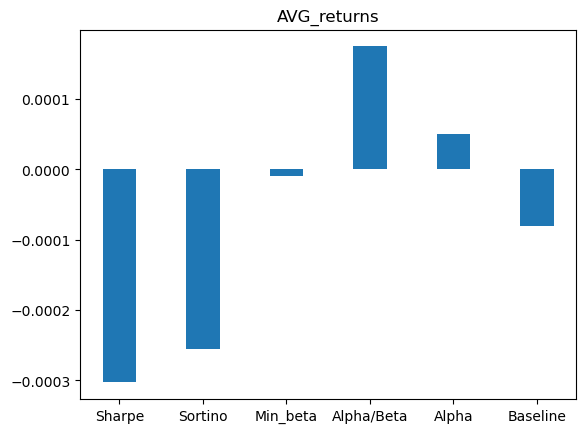

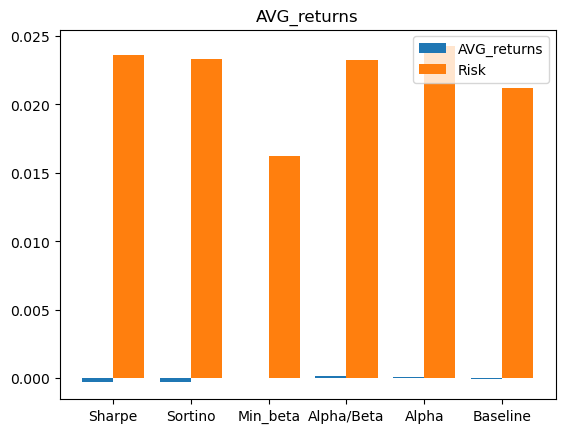

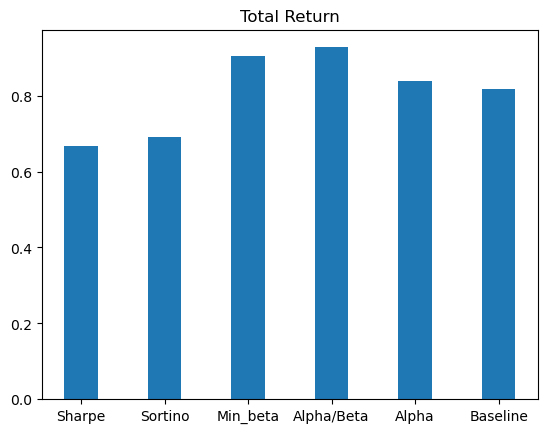

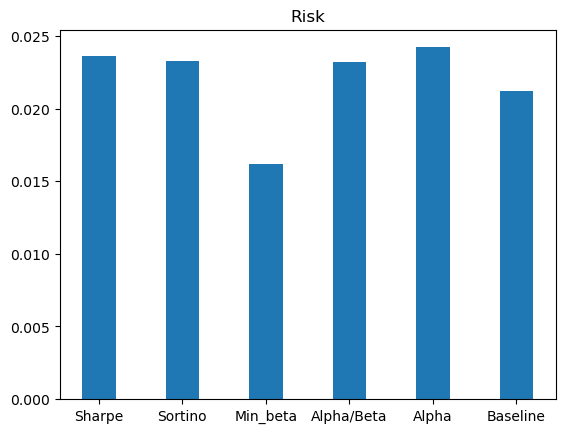

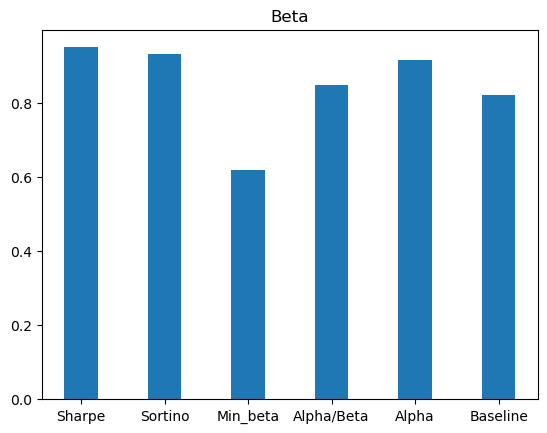

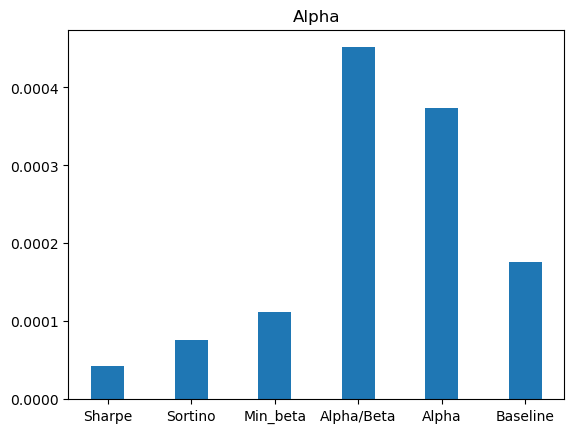

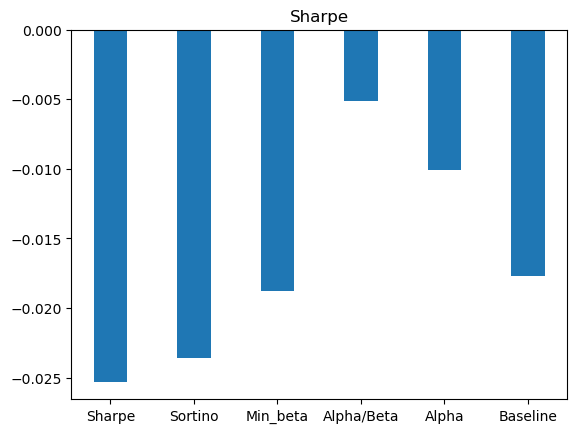

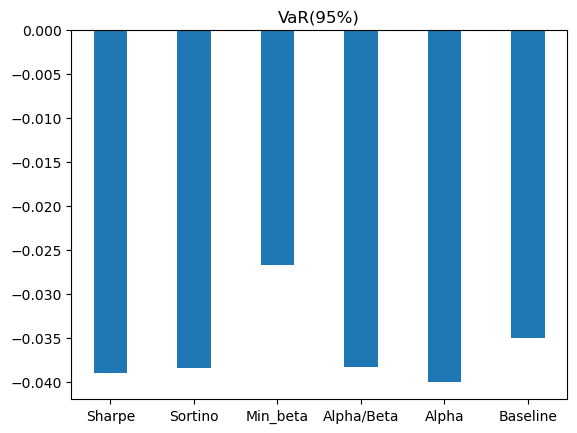

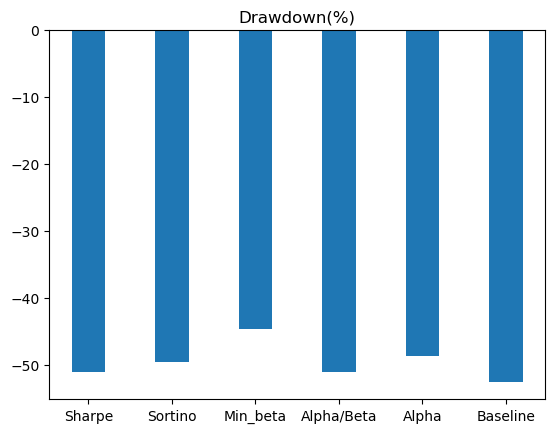

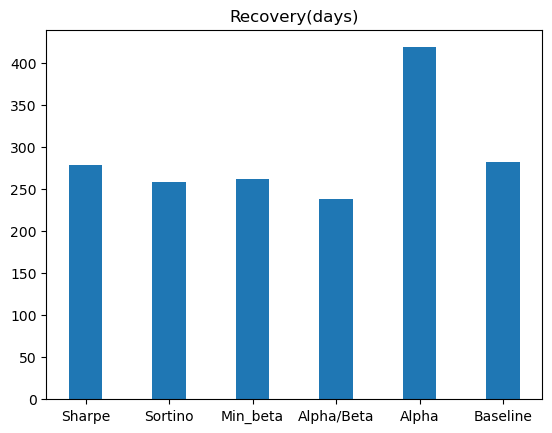

In [41]:
#args: df_metr, port, method

srez = get_srez(test,'Sharpe')

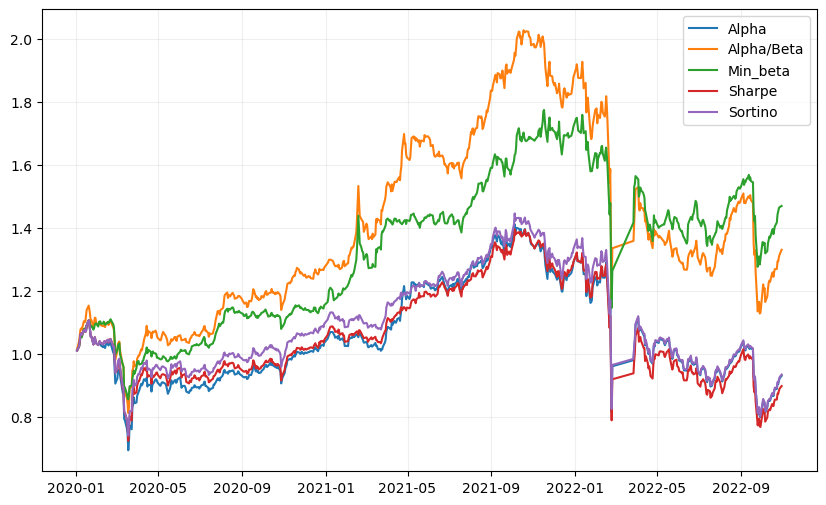

In [69]:
gg = price_srez(all_pr,'Tobin')

In [48]:
all_pr

,Markowitz,Sharpe,Tobin,market,Method
Date,,,,,
2020-01-03,1.017334,1.015570,1.011578,1.010093,Sharpe
2020-01-06,1.032363,1.030710,1.025684,1.011607,Sharpe
2020-01-08,1.041843,1.055097,1.063684,1.023136,Sharpe
2020-01-09,1.046950,1.054208,1.065889,1.025269,Sharpe
2020-01-10,1.054211,1.054434,1.061465,1.026528,Sharpe
...,...,...,...,...,...
2022-10-25,0.910570,0.822965,0.907737,0.630012,Alpha
2022-10-26,0.908543,0.817196,0.905255,0.627220,Alpha
2022-10-27,0.918395,0.835247,0.915115,0.640100,Alpha


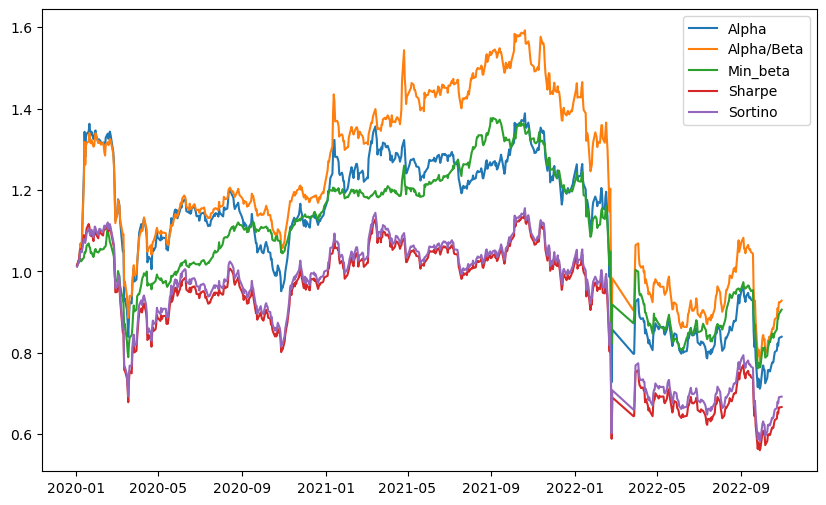

Method,Alpha,Alpha/Beta,Min_beta,Sharpe,Sortino
Date,,,,,
2020-01-03,1.012706,1.013477,1.015728,1.015570,1.011591
2020-01-06,1.027437,1.030286,1.022638,1.030710,1.025345
2020-01-08,1.067537,1.068670,1.030788,1.055097,1.050267
2020-01-09,1.067871,1.066353,1.024682,1.054208,1.048438
2020-01-10,1.070926,1.065399,1.027324,1.054434,1.047262
...,...,...,...,...,...
2022-10-25,0.822965,0.909166,0.880096,0.654045,0.679564
2022-10-26,0.817196,0.902874,0.884512,0.650831,0.675963
2022-10-27,0.835247,0.924307,0.895868,0.664900,0.690356


In [61]:
# args: df_price, port, method
pr_srez = price_srez(all_pr, port = 'Sharpe')
pr_srez

In [44]:
aa = set(ports['Sharpe'])-set(ports['Sortino'])

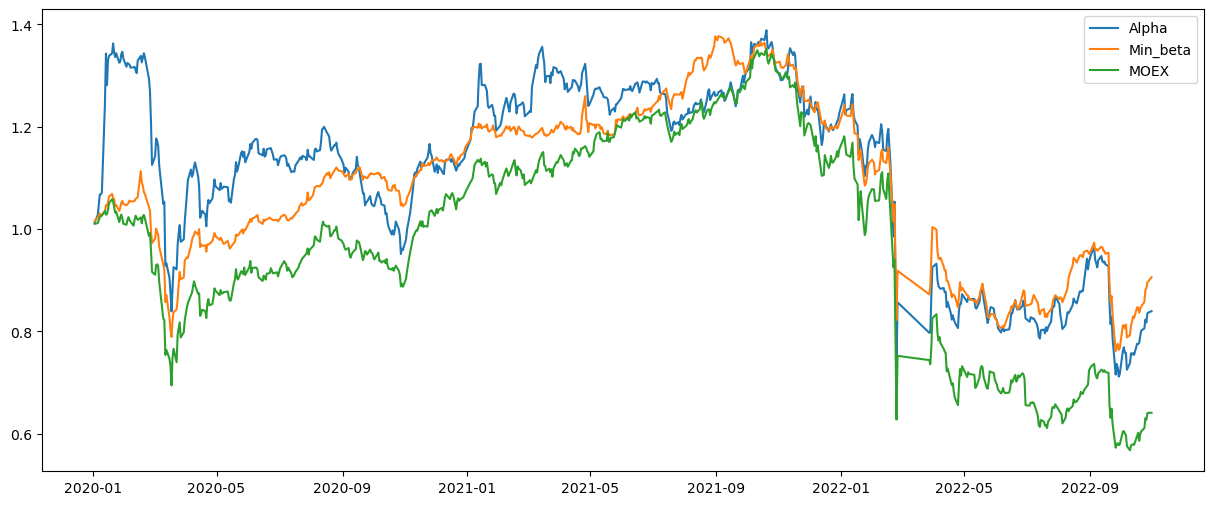

In [45]:
from matplotlib.pyplot import figure

aa = pr_srez.drop(['Sortino', 'Alpha/Beta', 'Sharpe'], axis=1)

plt.figure(figsize=(15,6))
plt.plot(aa)
plt.legend(aa.columns)
plt.show()